# NB1: MPR framework

## module loading...

In [1]:
%matplotlib inline

import os
import sys
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

sys.path.append('../')


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
from mpr import print_date
print_date()

from mpr.IO import load_geophysical_attributes, GEO_ATTR_TYPE
from mpr.IO import load_mapping_data

from mpr.scaling import horizontal_weighted_mean

Last executed: 2021-04-13 18:04:16.402883 by mizukami on crhtc58


In [3]:
xr.set_options(file_cache_maxsize=12000);

In [ ]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

In [ ]:
#from dask.distributed import Client
#client = Client(cluster)

In [ ]:
#client

-------------------------
## Setup 

In [4]:
mpr_data_dir = '/glade/p/ral/hap/mizukami/pnw-extrems/geospatial_data/geophysical/data_mpr'

In [5]:
mapping_file = 'spatialweights_grid_600m_to_HUC12.nc'
mapping_vars = ['polyid', 'overlaps', 'weight', 'i_index', 'j_index']

## 1. Load the data

### 1.1. geophysical attributes



In [6]:
attr_data = load_geophysical_attributes()

loading geophysical attributes...


In [7]:
attr_data[GEO_ATTR_TYPE['soil']['bulk_density']]

<xarray.DataArray 'bulk_density' (lyr: 6, lat: 1881, lon: 2402)>
[27108972 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 41.25 41.25 41.26 41.27 ... 52.98 52.98 52.99 53.0
  * lon      (lon) float64 -125.0 -125.0 -125.0 -125.0 ... -110.0 -110.0 -110.0
Dimensions without coordinates: lyr
Attributes:
    long_name:  bulk density
    units:      kg/m^3
    associate:  ZYX

### 1.2. mapping weight

In [8]:
mapping_data = load_mapping_data(root=mpr_data_dir, file=mapping_file, var_list=mapping_vars)

loading mapping weight data...


In [9]:
mapping_data 

<xarray.Dataset>
Dimensions:   (data: 2975825, polyid: 9877)
Coordinates:
  * polyid    (polyid) int64 780093440000 780134400000 ... 171001020408
Dimensions without coordinates: data
Data variables:
    overlaps  (polyid) int32 ...
    weight    (data) float64 ...
    i_index   (data) int32 ...
    j_index   (data) int32 ...

## 2. Compute parameters

In [10]:
# temp transfer function for porosity
kgm3_to_gcm3 = 0.001
porosity = 0.788 + 0.001*attr_data['clay_pct']- 0.263*attr_data['bulk_density']*kgm3_to_gcm3

In [11]:
porosity

<xarray.DataArray (lyr: 6, lat: 1881, lon: 2402)>
array([[[       nan,        nan,        nan, ..., 0.44164094,
         0.44926792, 0.461577  ],
        [       nan,        nan,        nan, ..., 0.43953693,
         0.44558594, 0.45789498],
        [       nan,        nan,        nan, ..., 0.441326  ,
         0.44968995, 0.45726496],
        ...,
        [0.55977696, 0.55688393, 0.559514  , ..., 0.55999696,
         0.5576819 , 0.555578  ],
        [0.562459  , 0.561933  , 0.56424797, ..., 0.5537369 ,
         0.553     , 0.55347395],
        [0.566404  , 0.56693   , 0.567456  , ..., 0.5526819 ,
         0.55347097, 0.55389297]],

       [[       nan,        nan,        nan, ..., 0.44832298,
         0.45521298, 0.46646994],
        [       nan,        nan,        nan, ..., 0.44495597,
         0.45126796, 0.46357697],
        [       nan,        nan,        nan, ..., 0.44700795,
         0.45589793, 0.46294695],
...
        [0.4447419 , 0.44468996, 0.44626796, ..., 0.41887295,
         0.41839895, 0.41818798],
        [0.44737193, 0.44816092, 0.45100197, ..., 0.41582096,
         0.41508391, 0.41587293],
        [0.44973892, 0.45157993, 0.45263192, ..., 0.41134697,
         0.41318798, 0.41366196]],

       [[       nan,        nan,        nan, ..., 0.41176596,
         0.40729496, 0.40308693],
        [       nan,        nan,        nan, ..., 0.41255495,
         0.41045097, 0.40729496],
        [       nan,        nan,        nan, ..., 0.41223994,
         0.41039893, 0.40903193],
        ...,
        [0.43206596, 0.43101397, 0.43411794, ..., 0.40945694,
         0.40871996, 0.4087719 ],
        [0.43290693, 0.4336959 , 0.43653697, ..., 0.4064049 ,
         0.4064049 , 0.4061939 ],
        [0.4336959 , 0.43527392, 0.43685192, ..., 0.40293097,
         0.40477195, 0.40398297]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 41.25 41.25 41.26 41.27 ... 52.98 52.98 52.99 53.0
  * lon      (lon) float64 -125.0 -125.0 -125.0 -125.0 ... -110.0 -110.0 -110.0
Dimensions without coordinates: lyr

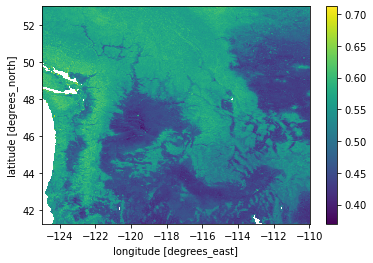

In [12]:
porosity[0,:,:].plot.pcolormesh();

## 3. Vertical scaling for soil layer parameters

## 4. Horizontal scaling for all the parameters

In [66]:
wgtedVals = horizontal_weighted_mean(matWgts, matIndex_i, matIndex_j, polyid, overlaps, porosity.values[0:3,:,:], 1)
print(wgtedVals.shape)
wgtedVals

(3, 9877)


array([[0.5836338 , 0.56808686, 0.45051718, ..., 0.54108715, 0.4986115 ,
               nan],
       [0.56100744, 0.5372086 , 0.44674134, ..., 0.5268147 , 0.48208332,
               nan],
       [0.5167861 , 0.4969681 , 0.43794668, ..., 0.4940487 , 0.46198618,
               nan]], dtype=float32)

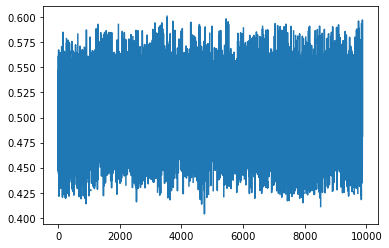

In [16]:
plt.plot(wgtedVals[1,:])

## 5. Output final parameters

##  Experiment

In [14]:
# weight data reformat

# set to zero based index and flip the N-S index (for read-in data array 0,0 is SW-corner)

polyid  = mapping_data['polyid'].values
overlaps= mapping_data['overlaps'].values
weight  = mapping_data['weight'].values
i_index = mapping_data['i_index'].values
j_index = mapping_data['j_index'].values


j_index = j_index - 1              # j_index starts at North, and at 1 ... make 0-based
i_index = i_index - 1              # i_index starts at West, and a 1 ... make 0-based

# check run end limits and calculate some useful dimensions
nOutPolys = len(polyid)
maxOverlaps = overlaps.max()

# assign weights and indices to a regular array (nOutPolys x maxOverlaps)
matWgts    = np.zeros((nOutPolys, maxOverlaps), dtype='float32')
matIndex_i = np.zeros((nOutPolys, maxOverlaps), dtype='int32')
matIndex_j = np.zeros((nOutPolys, maxOverlaps), dtype='int32')

ix2=0;
for p in range(0, nOutPolys):
    if overlaps[p]>0:
        ix1 = ix2 
        ix2 = ix1+overlaps[p]
    elif overlaps[p]==0 and flag: # WARNNG: grid2poly.py output skip data in data dimension, but poly2poly put missing values in data dimension
        ix1 = ix2 
        ix2 = ix2+1
    elif overlaps[p]==0 and not flag:
        matWgts[p, 0:overlaps[p]] = 0 
        matWgts[p, 0] = 1.0 
        continue
        
    matWgts[p, 0:overlaps[p]]    = weight[ix1:ix2]/weight[ix1:ix2].sum()
    matIndex_i[p, 0:overlaps[p]] = i_index[ix1:ix2]
    matIndex_j[p, 0:overlaps[p]] = j_index[ix1:ix2]
print("Pre-process weight and index arrays")

Pre-process weight and index arrays


In [74]:
FILL_VALUE = -9999.0
def horizontal_weighted_mean_test(matWgts, matIndex_i, matIndex_j, targetPolyIDs, overlaps, origArrays, pvalue, default=FILL_VALUE):
    """Compute areal weighted generalized mean value of for all output polygons
       """
    
    # numpy broadcasting rule
    # https://numpy.org/doc/stable/user/basics.broadcasting.html
    
    # ogirinal grid: 2D [lat, lon] -       > target grid: 1D [hru]
    # ogirinal grid: 3D [Month, lat, lon] -> target grid: 2D [Month, hru]
    #                   [lyr, lat, lon] -> target grid: 2D [lyr, hru]
    
    array_shape = origArrays.shape
    nDims       = len(array_shape)
    
    # TODO
    # move these out of function
    nOutHRUs    = len(overlaps)
    maxOverlaps = overlaps.max()
    
    if nDims == 2:
        wgtedVals   = np.zeros((nOutHRUs), dtype='float32')
        matDataVals = np.zeros((nOutHRUs, maxOverlaps), dtype='float32')
    elif nDims == 3:
        wgtedVals   = np.zeros((array_shape[0], nOutHRUs), dtype='float32')
        matDataVals = np.zeros((array_shape[0], nOutHRUs, maxOverlaps), dtype='float32')
    else:
        pass # add error check - array with 4 or larger dimension is not supported.

    # reformat var data into regular matrix matching weights format (nOutPolygons, maxOverlaps)
    #   used advanced indexing to extract matching input grid indices
    for iHru in range(0, nOutHRUs):
        if overlaps[iHru]>0:
            if nDims == 2:
                matDataVals[iHru, 0:overlaps[iHru]] = \
                    origArrays[matIndex_j[iHru, 0:overlaps[iHru]], matIndex_i[iHru, 0:overlaps[iHru]] ]
            elif nDims == 3:
                matDataVals[:, iHru, 0:overlaps[iHru]] = \
                    origArrays[:, matIndex_j[iHru, 0:overlaps[iHru]], matIndex_i[iHru, 0:overlaps[iHru]] ]
        else:
            if nDims == 2:
                matDataVals[iHru, 0] = default
            elif nDims == 3:
                matDataVals[:, iHru, 0] = default
 
    if abs(pvalue) < 0.00001: # geometric mean
        wgtedVals = exp(np.sum(log(matDataVals)* matWgts, axis=nDims-1))
    else:
        wgtedVals = np.nansum(matDataVals**pvalue * matWgts, axis=nDims-1) **(1.0/pvalue)   # produces vector of weighted values
    return wgtedVals

In [84]:
wgtedVals = horizontal_weighted_mean_test(matWgts, matIndex_i, matIndex_j, polyid, overlaps, porosity.values[0,:,:], 1)
wgtedVals

array([0.5836338 , 0.56808686, 0.45051718, ..., 0.54108715, 0.4986115 ,
       0.5716425 ], dtype=float32)

In [85]:
matIndex_i[-1,0:overlaps[-1]]
matIndex_j[-1,0:overlaps[-1]]

matDataVals = np.zeros((1, maxOverlaps), dtype='float32')
matDataVals.shape

(1, 2898)

In [86]:
matWgts.shape

(9877, 2898)

In [87]:
matDataVals[0, 0:overlaps[-1]].shape

(375,)

In [90]:
porsity_array = porosity[0,:,:].values
matDataVals[0, 0:overlaps[-1]] = porsity_array[matIndex_j[-1,0:overlaps[-1]], matIndex_i[-1,0:overlaps[-1]]]

In [93]:
matDataVals*matWgts[-1,:]

array([[0.00067446, 0.00193413, 0.00193069, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [61]:
matWgts[-1,:]

array([0.0011317 , 0.00327281, 0.00327281, ..., 0.        , 0.        ,
       0.        ], dtype=float32)